In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import torchvision
image_path = '../data/'
celeba_dataset = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=False)
assert isinstance(celeba_dataset, torch.utils.data.Dataset)

In [14]:
print(list(enumerate(celeba_dataset.attr_names)))

[(0, '5_o_Clock_Shadow'), (1, 'Arched_Eyebrows'), (2, 'Attractive'), (3, 'Bags_Under_Eyes'), (4, 'Bald'), (5, 'Bangs'), (6, 'Big_Lips'), (7, 'Big_Nose'), (8, 'Black_Hair'), (9, 'Blond_Hair'), (10, 'Blurry'), (11, 'Brown_Hair'), (12, 'Bushy_Eyebrows'), (13, 'Chubby'), (14, 'Double_Chin'), (15, 'Eyeglasses'), (16, 'Goatee'), (17, 'Gray_Hair'), (18, 'Heavy_Makeup'), (19, 'High_Cheekbones'), (20, 'Male'), (21, 'Mouth_Slightly_Open'), (22, 'Mustache'), (23, 'Narrow_Eyes'), (24, 'No_Beard'), (25, 'Oval_Face'), (26, 'Pale_Skin'), (27, 'Pointy_Nose'), (28, 'Receding_Hairline'), (29, 'Rosy_Cheeks'), (30, 'Sideburns'), (31, 'Smiling'), (32, 'Straight_Hair'), (33, 'Wavy_Hair'), (34, 'Wearing_Earrings'), (35, 'Wearing_Hat'), (36, 'Wearing_Lipstick'), (37, 'Wearing_Necklace'), (38, 'Wearing_Necktie'), (39, 'Young'), (40, '')]


tensor(0)


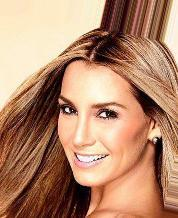

In [20]:
print(celeba_dataset.attr[0][20])
celeba_dataset[0][0]

In [32]:
male_indices = [i for i in range(len(celeba_dataset)) if celeba_dataset.attr[i, 20] == 1]
female_indices = [i for i in range(len(celeba_dataset)) if celeba_dataset.attr[i, 20] == 0]
len(male_indices), len(female_indices)

(68261, 94509)

In [36]:
from torch.utils.data import Subset
import random
subset_male_indices = random.sample(male_indices, 1000)
subset_female_indices = random.sample(female_indices, 1000)

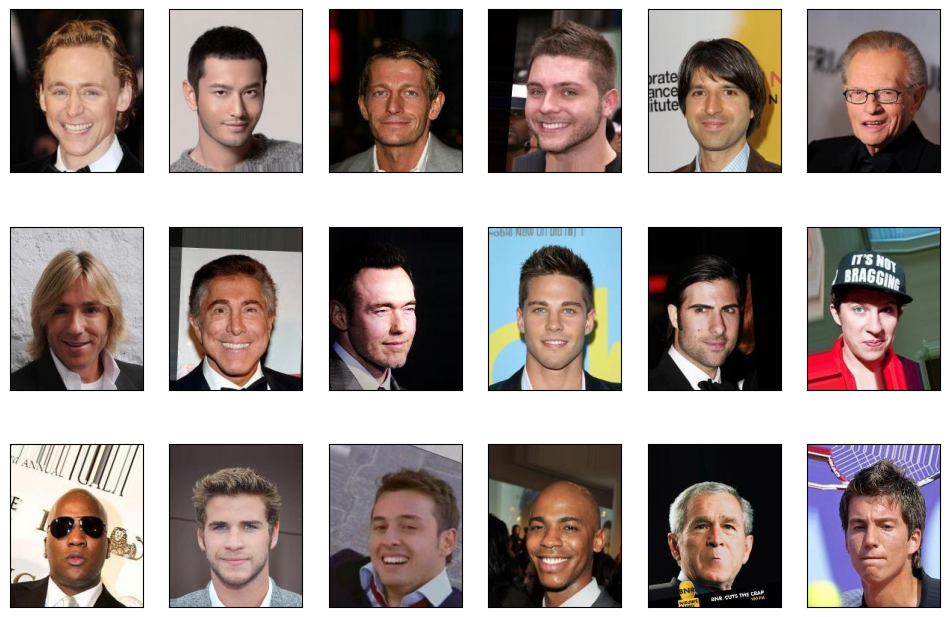

In [40]:
fig = plt.figure(figsize=(12, 8))
for i in range(18):
    img = celeba_dataset[subset_male_indices[i]][0]
    ax = fig.add_subplot(3, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
plt.show()

In [ ]:
subset_indices = subset_male_indices + subset_female_indices
random.shuffle(subset_indices)

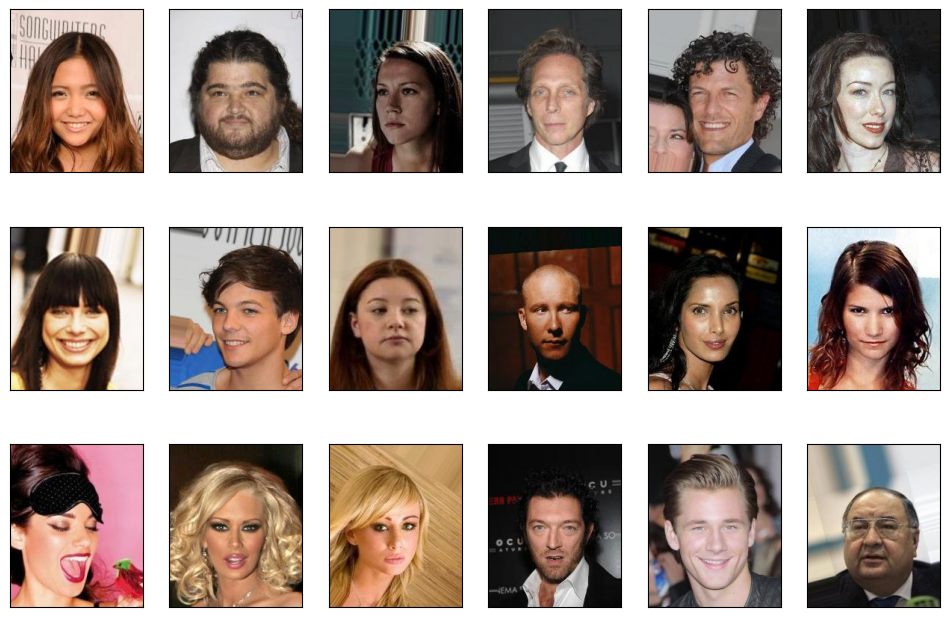

In [43]:
fig = plt.figure(figsize=(12, 8))
for i in range(18):
    img = celeba_dataset[subset_indices[i]][0]
    ax = fig.add_subplot(3, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
plt.show()

In [ ]:
subset_dataset = Subset(celeba_dataset, subset_indices)

In [81]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [82]:
from torch.utils.data import Dataset
class ImageDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        img, lbl = subset_dataset[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, lbl[20]

    def __len__(self):
        return len(subset_dataset)

In [83]:
custom_dataset = ImageDataset(transform=transform)

In [84]:
from torch.utils.data import DataLoader
batch_size=16

train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [85]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([16, 1, 32, 32])
torch.Size([16])


In [90]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [91]:
input_size = 32*32
model = Model(input_size)

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 20
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_loader:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
    loss_hist[epoch] /= len(train_loader.dataset)
    accuracy_hist[epoch] /= len(train_loader.dataset)
    print(f'Epoch {epoch} Loss {loss_hist[epoch]} Accuracy {accuracy_hist[epoch]}')

Epoch 0 Loss 0.5734030766487122 Accuracy 0.7005000114440918
Epoch 1 Loss 0.44770239281654356 Accuracy 0.7919999957084656
Epoch 2 Loss 0.3862746270298958 Accuracy 0.8299999833106995
Epoch 3 Loss 0.31668804702162745 Accuracy 0.8669999837875366
Epoch 4 Loss 0.28936725670099256 Accuracy 0.871999979019165
Epoch 5 Loss 0.24145750758051873 Accuracy 0.8980000019073486
Epoch 6 Loss 0.1939037826359272 Accuracy 0.9235000014305115
Epoch 7 Loss 0.18851244746148585 Accuracy 0.9135000109672546
Epoch 8 Loss 0.16909186201542617 Accuracy 0.9290000200271606
Epoch 9 Loss 0.14047930231690406 Accuracy 0.9459999799728394
Epoch 10 Loss 0.13285385842993855 Accuracy 0.949999988079071
Epoch 11 Loss 0.11951744802296162 Accuracy 0.9545000195503235
Epoch 12 Loss 0.08816752926632762 Accuracy 0.9660000205039978
Epoch 13 Loss 0.10876403486728668 Accuracy 0.9585000276565552
Epoch 14 Loss 0.06507946858275682 Accuracy 0.9750000238418579
Epoch 15 Loss 0.06068657686328515 Accuracy 0.9789999723434448
Epoch 16 Loss 0.0825711

In [ ]:
wrong = []
def predict(index):
    return torch.argmax(model(transform(celeba_dataset[index][0])), dim=1)

for i in female_indices[1000:2000]:
    if predict(i) != 0:
        wrong.append(i)

In [118]:
len(wrong)/1000

0.156

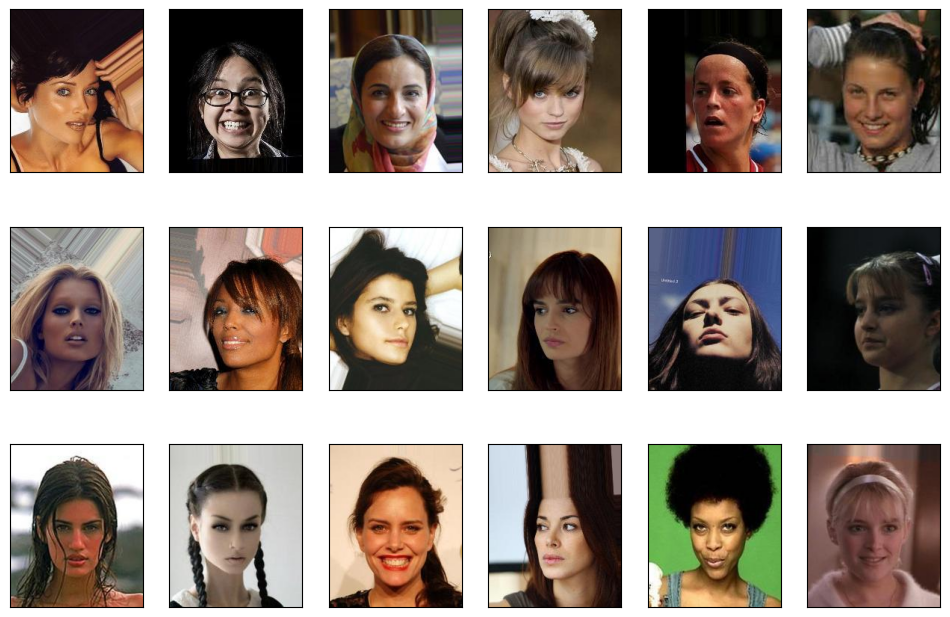

In [119]:
fig = plt.figure(figsize=(12, 8))
for i in range(18):
    img = celeba_dataset[wrong[i]][0]
    ax = fig.add_subplot(3, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
plt.show()

In [120]:
wrong = []
def predict(index):
    return torch.argmax(model(transform(celeba_dataset[index][0])), dim=1)

for i in male_indices[1000:2000]:
    if predict(i) != 1:
        wrong.append(i)

In [121]:
len(wrong)/1000

0.146

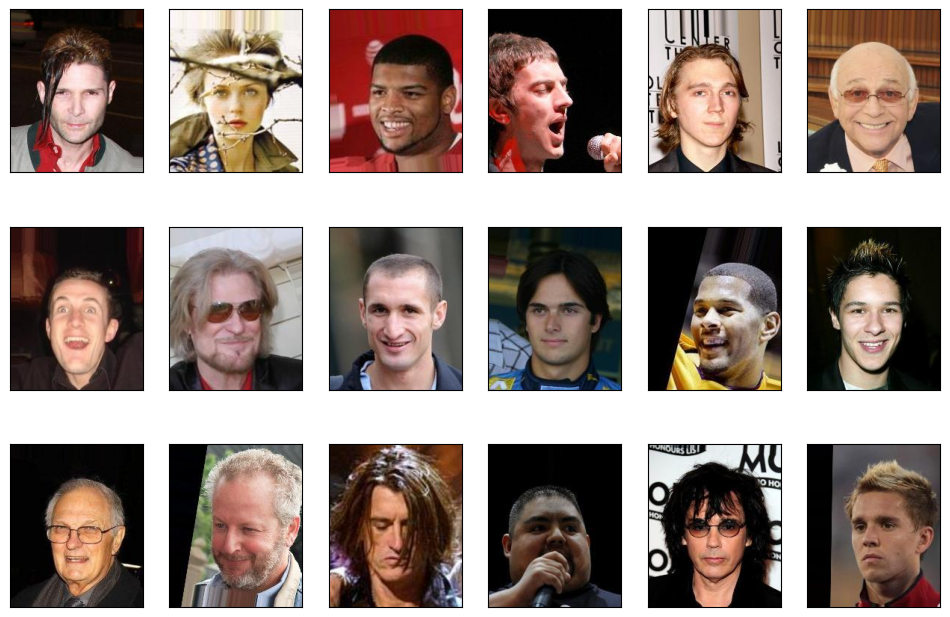

In [122]:
fig = plt.figure(figsize=(12, 8))
for i in range(18):
    img = celeba_dataset[wrong[i]][0]
    ax = fig.add_subplot(3, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
plt.show()